In [1]:
%%time

import warnings
warnings.filterwarnings('ignore')

CPU times: user 42 µs, sys: 10 µs, total: 52 µs
Wall time: 56.5 µs


In [2]:
%%time

import tensorflow as tf
import tensorflow_hub as hub

# Load the YAMNet model from TensorFlow Hub
yamnet_model = hub.load('https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1')

CPU times: user 12.7 s, sys: 1.66 s, total: 14.4 s
Wall time: 21.1 s


Processing audio files...
Processed: XC342638.ogg - Class: Speech - Confidence: 0.447
Processed: XC745831.ogg - Class: Animal - Confidence: 0.260
Processed: XC741066.ogg - Class: Environmental noise - Confidence: 0.428
Processed: XC629846.ogg - Class: Animal - Confidence: 0.203
Processed: XC600171.ogg - Class: Animal - Confidence: 0.314
Processed: XC665386.ogg - Class: Wild animals - Confidence: 0.335
Processed: XC267679.ogg - Class: Wind - Confidence: 0.150
Processed: XC554430.ogg - Class: Animal - Confidence: 0.372
Processed: XC175797.ogg - Class: Animal - Confidence: 0.636
Processed: XC629847.ogg - Class: Animal - Confidence: 0.221
Processed: XC687954.ogg - Class: Speech - Confidence: 0.299
Processed: XC49755.ogg - Class: Wild animals - Confidence: 0.510
Processed: XC677470.ogg - Class: Environmental noise - Confidence: 0.406
Processed: XC749597.ogg - Class: Animal - Confidence: 0.150
Processed: XC267680.ogg - Class: Animal - Confidence: 0.497
Processed: XC164848.ogg - Class: Enviro

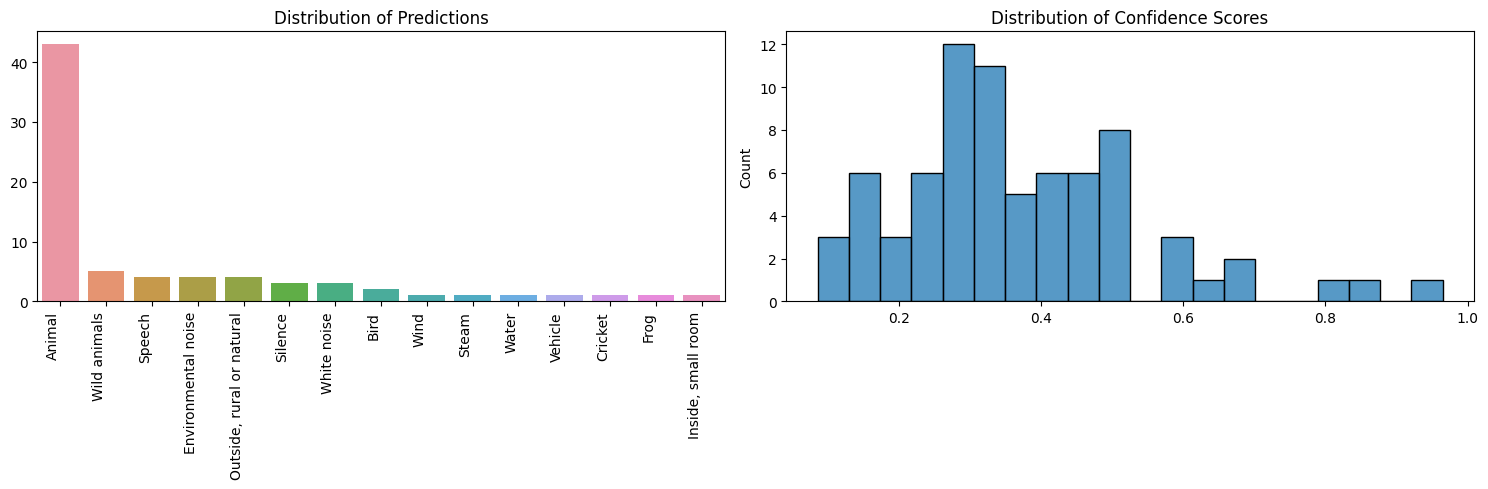

CPU times: user 7.19 s, sys: 460 ms, total: 7.65 s
Wall time: 7.23 s


In [6]:
%%time

import os
import librosa
import numpy as np
import soundfile as sf  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import io
import csv

# Function to extract class names from the model's class_map_path
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    class_map_csv = io.StringIO(class_map_csv_text)
    # Skip the header
    csv_reader = csv.reader(class_map_csv)
    next(csv_reader)
    class_names = [display_name for (class_index, mid, display_name) in csv_reader]
    return class_names

# Load class names from the model's class_map_path
class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))

def preprocess_audio(audio_file_path, target_sr=22050):
    """
    Preprocess audio file for YAMNet input.

    Parameters:
    -----------
    audio_file_path : str
        Path to audio file
    target_sr : int
        Target sampling rate (YAMNet expects 16kHz)
        
    Returns:
    --------
    numpy array : Preprocessed audio waveform
    """
    try:
        # Load and resample audio 
        waveform, sr = librosa.load(audio_file_path, sr=target_sr)
        
        # Ensure minimum duration (1 second)
        if len(waveform) < target_sr:
            waveform = np.pad(waveform, (0, target_sr - len(waveform)))
        
        return waveform
        
    except Exception as e:
        print(f"Error processing {audio_file_path}: {str(e)}")
        return None

def classify_audio_file(audio_file_path):
    """
    Classify audio file using YAMNet.

    Parameters:
    -----------
    audio_file_path : str
        Path to audio file
        
    Returns:
    --------
    tuple : (predicted_class, confidence_score)
    """
    try:
        # Preprocess audio
        waveform = preprocess_audio(audio_file_path, target_sr=22050)  # YAMNet expects 16kHz
        if waveform is None:
            return None, None
        
        # Run the model
        scores, embeddings, spectrogram = yamnet_model(waveform)
        
        # Get the predicted class and confidence
        class_scores = scores.numpy().mean(axis=0)
        predicted_class_idx = np.argmax(class_scores)
        confidence_score = class_scores[predicted_class_idx]
        
        # Get class name from the loaded class names
        predicted_class = class_names[predicted_class_idx]
        
        return predicted_class, confidence_score
        
    except Exception as e:
        print(f"Error classifying {audio_file_path}: {str(e)}")
        return None, None

def process_audio_directory(audio_directory, limit=75):
    """
    Process all audio files in a directory.

    Parameters:
    -----------
    audio_directory : str
        Path to directory containing audio files
    limit : int
        Maximum number of files to process
        
    Returns:
    --------
    list : List of (filename, prediction, confidence) tuples
    """
    results = []
    
    # Get list of audio files, including .ogg format
    audio_files = [f for f in os.listdir(audio_directory) 
                  if f.lower().endswith('.ogg')][:limit]
    
    # Process each file
    for audio_file in audio_files:
        audio_file_path = os.path.join(audio_directory, audio_file)
        predicted_class, confidence = classify_audio_file(audio_file_path)
        
        if predicted_class is not None:
            results.append((audio_file, predicted_class, confidence))
            print(f"Processed: {audio_file} - Class: {predicted_class} - Confidence: {confidence:.3f}")
    
    return results

def plot_results(results):
    """
    Plot classification results.

    Parameters:
    -----------
    results : list
        List of (filename, prediction, confidence) tuples
    """
    if not results:
        print("No results to plot.")
        return
    
    # Extract predictions and confidences
    predictions = [r[1] for r in results]
    confidences = [r[2] for r in results]
    
    # Plot distribution of predictions
    plt.figure(figsize=(15, 5))
    
    # Prediction distribution
    plt.subplot(1, 2, 1)
    pred_counts = pd.Series(predictions).value_counts()
    sns.barplot(x=pred_counts.index, y=pred_counts.values)
    plt.xticks(rotation=90, ha='right')
    plt.title('Distribution of Predictions')
    
    # Confidence distribution
    plt.subplot(1, 2, 2)
    sns.histplot(confidences, bins=20)
    plt.title('Distribution of Confidence Scores')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Directory containing the audio files
    audio_directory = '/kaggle/input/birdclef-2024/train_audio/asbfly'
    
    # Process audio files
    print("Processing audio files...")
    results = process_audio_directory(audio_directory, limit=75)
    
    # Create DataFrame 
    if results:
        df_results = pd.DataFrame(results, columns=['filename', 'prediction', 'confidence'])
    
        # Print summary statistics
        print("\nSummary Statistics:")
        print("-" * 50)
        print(f"Total files processed: {len(df_results)}")
        print("\nPrediction counts:")
        print(df_results['prediction'].value_counts().head())
        print("\nConfidence score statistics:")
        print(df_results['confidence'].describe())
        
        # Plot results
        plot_results(results)
    else:
        print("No audio files processed successfully.")